# DES	simulation	assignment
## Multiple queues and multiple servers


$\lambda$ – the arrival rate into the system as a whole. \
$\mu$ – the capacity of each of n equal servers. \
$\rho$ represents the system load. \
In a single server system, it will be: $\rho = \frac{\lambda}{\mu}$ \
In a multi-server system (one queue with n equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{(n \mu)}$

Queuing theory tells us that for FIFO scheduling the average waiting times are shorter for an
M/M/n queue and a system load ρ and processor capacity µ than for a single M/M/1 queue
with the same load characteristics (and thus an n-fold lower arrival rate). Of course, ρ must be
less than one, but the experiment only becomes interesting when ρ is not much less than one.

### 1) Look up and/or derive this theoretical result, at least for n=2. Describe how it is derived. Can you also give a non-mathematical explanation?

TODO

### 2) Write a DES program to verify this for n=1, n=2 and n=4. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on ρ?

M/M/n: \
Markovian/memoryless inter-arrival time distribution, so draw from exponential distribution \
Markovian/memoryless service time distribution, so draw from exponential distribution \ 
n servers \
Infinite queue \
Service queuing disciple = FIFO


In [1]:
import numpy as np
import pandas as pd
import simpy
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind, ttest_rel, shapiro

In [2]:
class MMNQueue:
    def __init__(self, env, n, rho, mu, scheduling='FIFO', service_distr = 'M'):
        self.env = env
        self.servers = [simpy.Resource(env) for _ in range(n)]
        self.mu = mu
        self.rho = rho
        self.lamda = rho*(n*mu)
        self.total_arrivals = 0
        self.total_complete_services = 0
        self.total_time_in_queue = 0
        self.arrival_times = []
        self.scheduling = scheduling
        self.service_distr = service_distr

    def arrival_process(self, num_customers):
        while self.total_arrivals < num_customers:
            yield self.env.timeout(np.random.exponential(1/self.lamda))
            self.total_arrivals += 1
            arrival_time = self.env.now
            self.arrival_times.append(arrival_time)
            self.env.process(self.service())

    def service(self):
        arrival_time = self.env.now

        if self.scheduling == 'FIFO':
            server = min(self.servers, key=lambda s: len(s.queue))
        elif self.scheduling == 'SJF':
            server = min(self.servers, key=lambda s: s.count)
        else:
            raise ValueError("Invalid Scheduling Method")

        with server.request() as req:
            yield req

            service_start_time = self.env.now
            
            if self.service_distr == 'M':
                service_time = np.random.exponential(1 / self.mu)
            elif self.service_distr == 'D':
                service_time = (1 / self.mu)
            elif self.service_distr == 'H2':
                service_time = hyperexponential_2_phases()
            else:
                raise ValueError("Invalid Service Time Distribution")

            yield self.env.timeout(service_time)

            departure_time = self.env.now
            self.total_complete_services += 1

            # Calculate time spent in the queue
            time_in_queue = service_start_time - arrival_time
            self.total_time_in_queue += time_in_queue

    def run_simulation(self, num_customers):
        self.env.process(self.arrival_process(num_customers))
        self.env.run(until=float('inf')) 

In [3]:
def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), np.std(data, ddof=1) / np.sqrt(n)
    h = se * t.ppf((1 + confidence) / 2, n - 1)
    return m, (m - h, m + h)

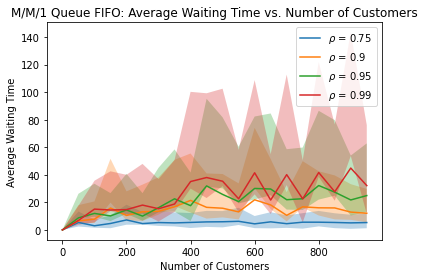

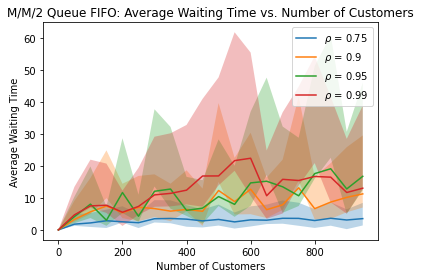

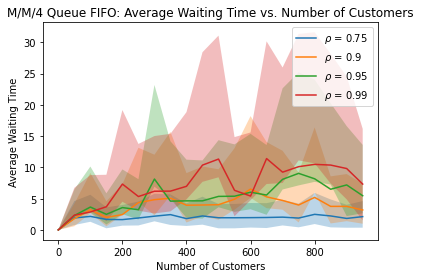

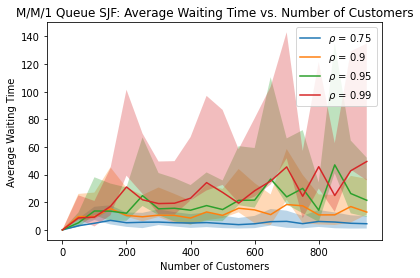

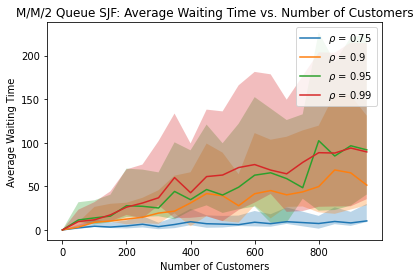

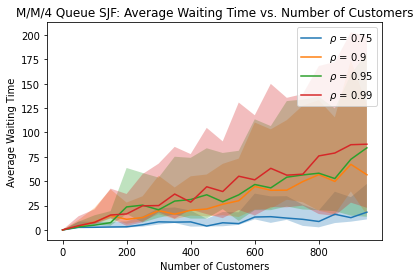

In [4]:
import time

def main():
    num_simulations = 5
    num_customers_values = np.arange(0, 1000, 50)
    rhos = [0.75, 0.9, 0.95, 0.99]
    mu = 1/2
    scheduling_policies = ['FIFO', 'SJF']
    results_data = []

    for scheduling_policy in scheduling_policies:
        for n in [1, 2, 4]:
            plt.figure()
            plt.title(f'M/M/{n} Queue {scheduling_policy}: Average Waiting Time vs. Number of Customers')
            plt.xlabel('Number of Customers')
            plt.ylabel('Average Waiting Time')

            prev_simulation_results = []  

            for rho in rhos:
                avg_waiting_times = []
                confidence_intervals = []
                simulation_times = []  # Added for measuring simulation time

                for num_customers in num_customers_values:
                    start_time = time.time()  # Record start time for the simulation

                    simulation_results = []

                    for _ in range(num_simulations):
                        env = simpy.Environment()
                        mmn_queue = MMNQueue(env, n, rho, mu, scheduling_policy)
                        mmn_queue.run_simulation(num_customers)

                        if mmn_queue.total_complete_services > 0:
                            avg_waiting_time = mmn_queue.total_time_in_queue / mmn_queue.total_complete_services
                            simulation_results.append(avg_waiting_time)
                        else:
                            simulation_results.append(0)

                    end_time = time.time()  # Record end time for the simulation
                    simulation_times.append(end_time - start_time)

                    avg_waiting_time, confidence_interval = calculate_confidence_interval(simulation_results)
                    avg_waiting_times.append(avg_waiting_time)
                    confidence_intervals.append(confidence_interval)
                    
                # Perform independent t-test between FIFO and SJF policies
                if prev_simulation_results:  # Check if not empty
                    _, p_value = ttest_ind(simulation_results, prev_simulation_results, equal_var = False)
                else:
                    p_value = np.nan

                # Update the results data
                results_data.append({
                    'Policy': scheduling_policy,
                    'Mu': mu,
                    'Rho': rho,
                    'N': n,
                    'Mean': round(np.mean(simulation_results), 4),
                    'SD': round(np.std(simulation_results), 4),
                    'CI_Lower': round(confidence_interval[0], 4),
                    'CI_Upper': round(confidence_interval[1], 4),
                    'P-Value': f'{p_value}',
                    'Simulation_Time': round(np.mean(simulation_times), 4)
                })

                prev_simulation_results = simulation_results

                # Plot the average waiting time
                plt.plot(num_customers_values, avg_waiting_times, label=f'$\\rho$ = {rho}')

                # Plot the shaded confidence interval
                plt.fill_between(num_customers_values,
                                np.array(avg_waiting_times) - np.array(confidence_intervals)[:, 0],
                                np.array(avg_waiting_times) + np.array(confidence_intervals)[:, 1],
                                alpha=0.3)

            plt.legend()
            plt.show()

    # Create a DataFrame and export to CSV
    results_df = pd.DataFrame(results_data)
    results_df.to_csv('simulation_results.csv', index=False)

if __name__ == "__main__":
    main()

## Question 2 & 3: Make pretty plots 

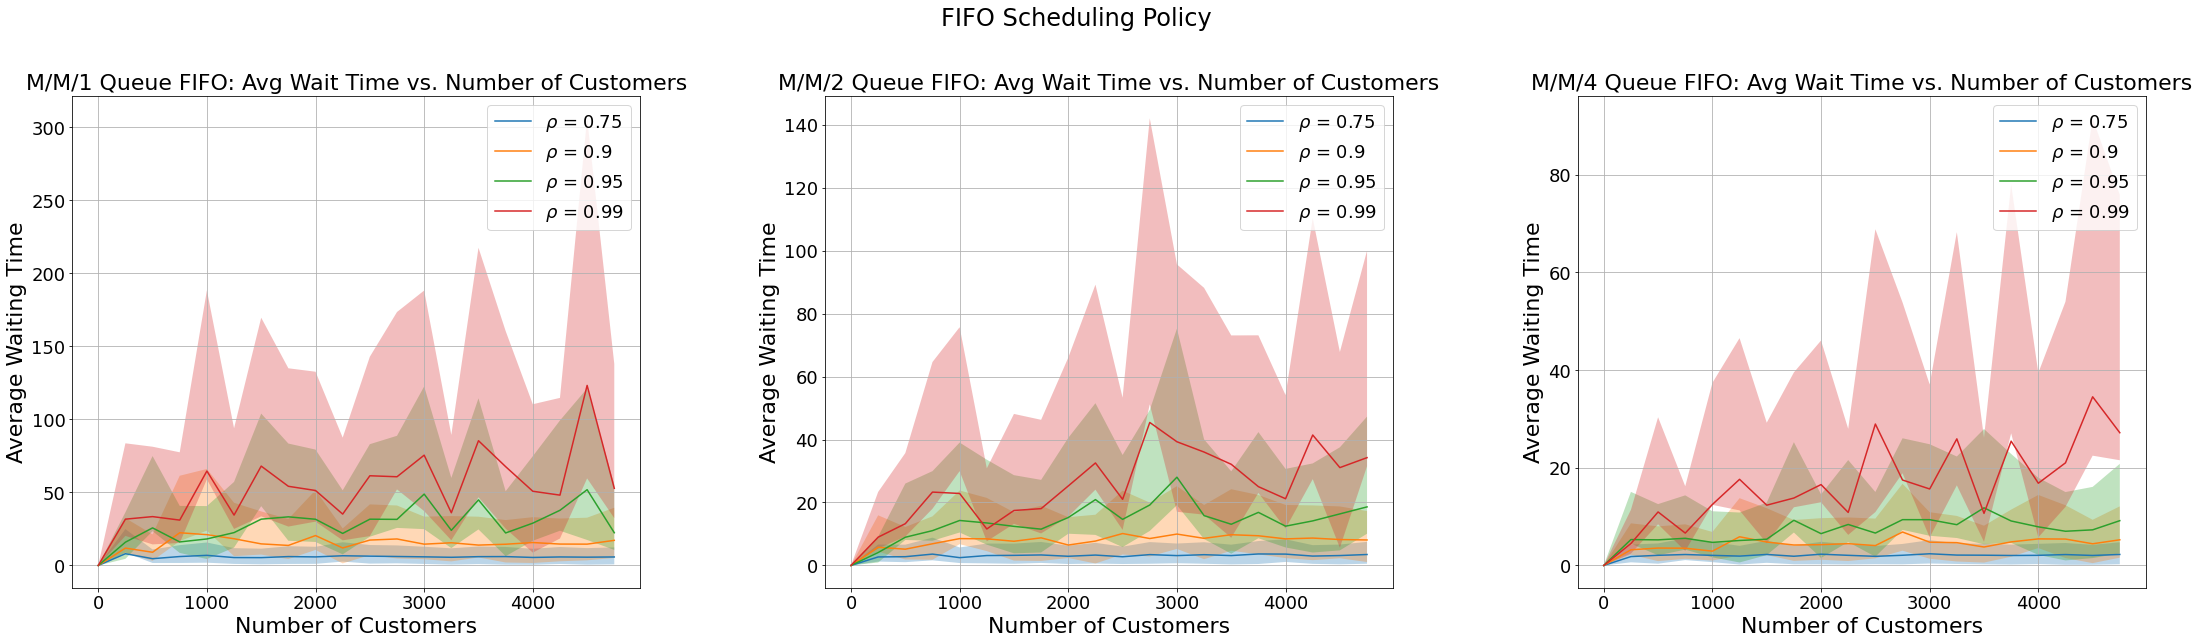

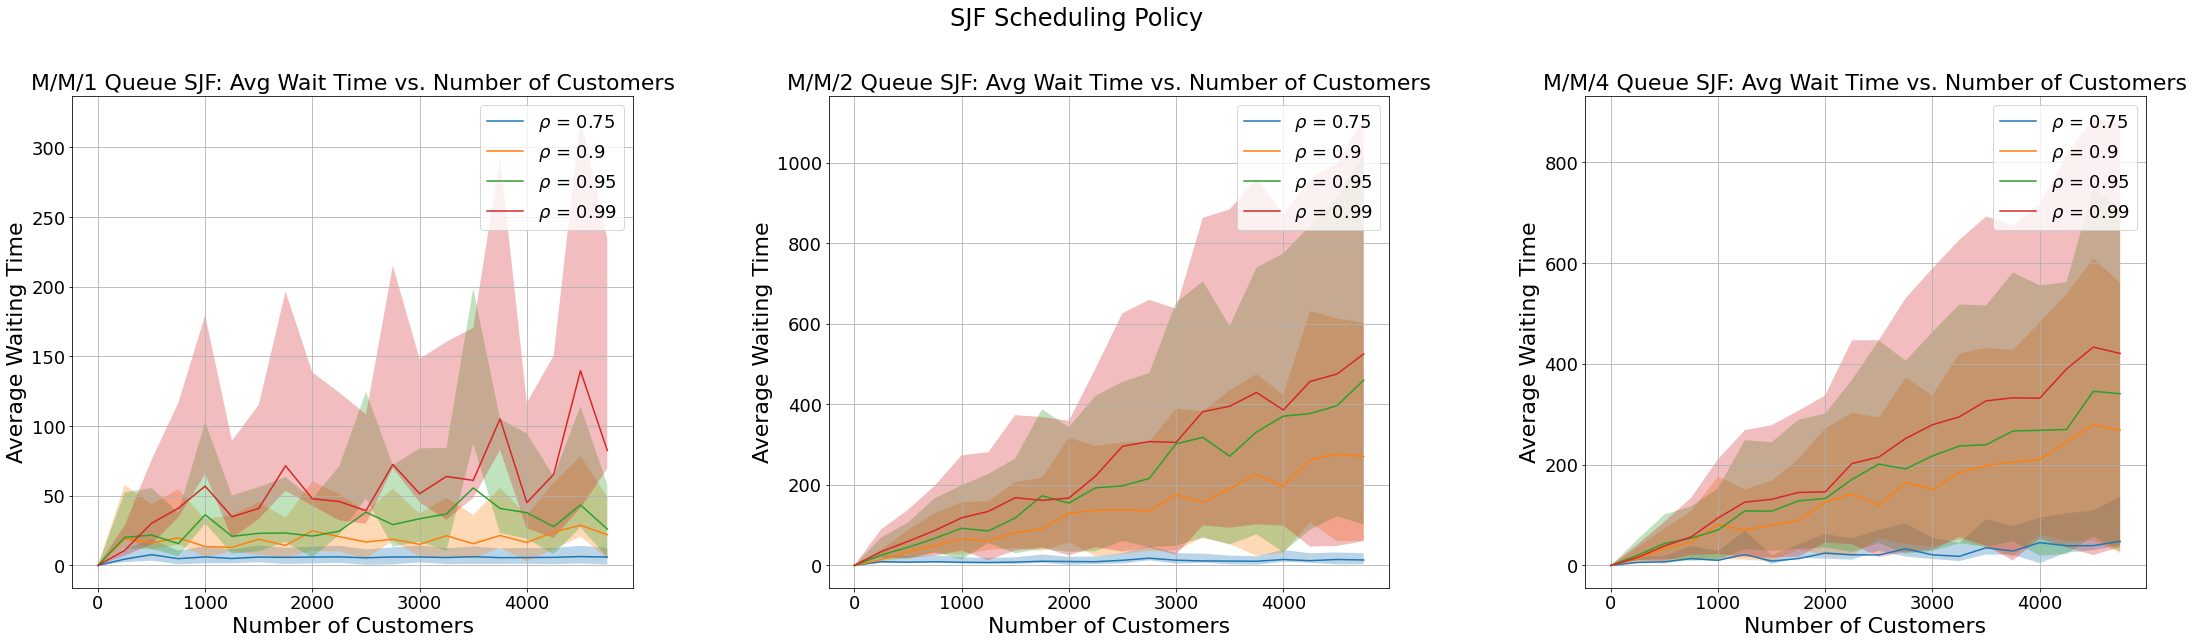

In [5]:
def main():
    num_simulations = 5
    num_customers_values = np.arange(0, 5000, 250)
    rhos = [0.75, 0.9, 0.95, 0.99]
    mu = 1/2
    scheduling_policies = ['FIFO', 'SJF']
    results_data = []

    for scheduling_policy in scheduling_policies:
        plt.figure(figsize=(30, 10))
        plt.suptitle(f'{scheduling_policy} Scheduling Policy', fontsize=24)

        for i, n in enumerate([1, 2, 4], start=1):
            if scheduling_policy == 'FIFO':
                plt.subplot(1, 3, i)
                plt.grid(True)
                plt.title(f'M/M/{n} Queue {scheduling_policy}: Avg Wait Time vs. Number of Customers', fontsize=22)
                plt.xlabel('Number of Customers', fontsize=22)
                plt.ylabel('Average Waiting Time', fontsize=22)
            else:
                plt.subplot(1, 3, i) 
                plt.grid(True)
                plt.title(f'M/M/{n} Queue {scheduling_policy}: Avg Wait Time vs. Number of Customers', fontsize=22)
                plt.xlabel('Number of Customers', fontsize=22)
                plt.ylabel('Average Waiting Time', fontsize=22)
                
            prev_simulation_results = []  

            for rho in rhos:
                avg_waiting_times = []
                confidence_intervals = []
                simulation_times = []  # Added for measuring simulation time

                for num_customers in num_customers_values:
                    start_time = time.time()  # Record start time for the simulation

                    simulation_results = []

                    for _ in range(num_simulations):
                        env = simpy.Environment()
                        mmn_queue = MMNQueue(env, n, rho, mu, scheduling_policy)
                        mmn_queue.run_simulation(num_customers)

                        if mmn_queue.total_complete_services > 0:
                            avg_waiting_time = mmn_queue.total_time_in_queue / mmn_queue.total_complete_services
                            simulation_results.append(avg_waiting_time)
                        else:
                            simulation_results.append(0)

                    end_time = time.time()  # Record end time for the simulation
                    simulation_times.append(end_time - start_time)

                    avg_waiting_time, confidence_interval = calculate_confidence_interval(simulation_results)
                    avg_waiting_times.append(avg_waiting_time)
                    confidence_intervals.append(confidence_interval)
                    
                # Perform independent t-test between FIFO and SJF policies
                if prev_simulation_results:  # Check if not empty
                    _, p_value = ttest_ind(simulation_results, prev_simulation_results, equal_var=False)
                else:
                    p_value = np.nan

                # Update the results data
                results_data.append({
                    'Policy': scheduling_policy,
                    'Mu': mu,
                    'Rho': rho,
                    'N': n,
                    'Mean': round(np.mean(simulation_results), 4),
                    'SD': round(np.std(simulation_results), 4),
                    'CI_Lower': round(confidence_interval[0], 4),
                    'CI_Upper': round(confidence_interval[1], 4),
                    'P-Value': f'{p_value}',
                    'Simulation_Time': round(np.mean(simulation_times), 4)
                })

                prev_simulation_results = simulation_results

                # Plot the average waiting time
                plt.plot(num_customers_values, avg_waiting_times, label=f'$\\rho$ = {rho}')

                # Plot the shaded confidence interval
                plt.fill_between(num_customers_values,
                                np.array(avg_waiting_times) - np.array(confidence_intervals)[:, 0],
                                np.array(avg_waiting_times) + np.array(confidence_intervals)[:, 1],
                                alpha=0.3)

            plt.legend(fontsize=18)  # Add legend with 'rho'

            # Increase font size of x and y-axis tick labels
            plt.tick_params(axis='both', which='both', labelsize=18)

        plt.tight_layout(rect=[0, 0.09, 1, 0.95], h_pad=2.0, w_pad=12)  # Adjust the layout with added vertical space
        plt.savefig(f'output_{scheduling_policy}.png')  # Save the plot as a PNG file
        plt.show()

    # Create a DataFrame and export to CSV
    results_df = pd.DataFrame(results_data)
    results_df.to_csv('simulation_results.csv', index=False)

if __name__ == "__main__":
    main()


## Question 4

In [6]:


def hyperexponential_2_phases(p_values = [0.75, 0.25], means = [1, 5]):
    '''Generates a single sample from a hyperexponential distribution.
    Input: p_values, list with probabilities for every phase, and means, list of means for every phase.
    Output: single sample from the hyperexponential distribution.
    '''
    if sum(p_values) != 1.0:
        raise ValueError("Probabilities must add up to 1!")
    
    choice_idx = np.random.choice(len(p_values), p=p_values)
    #TODO: INSERT SEED
    mean = means[choice_idx]
    
    return np.random.exponential(mean)



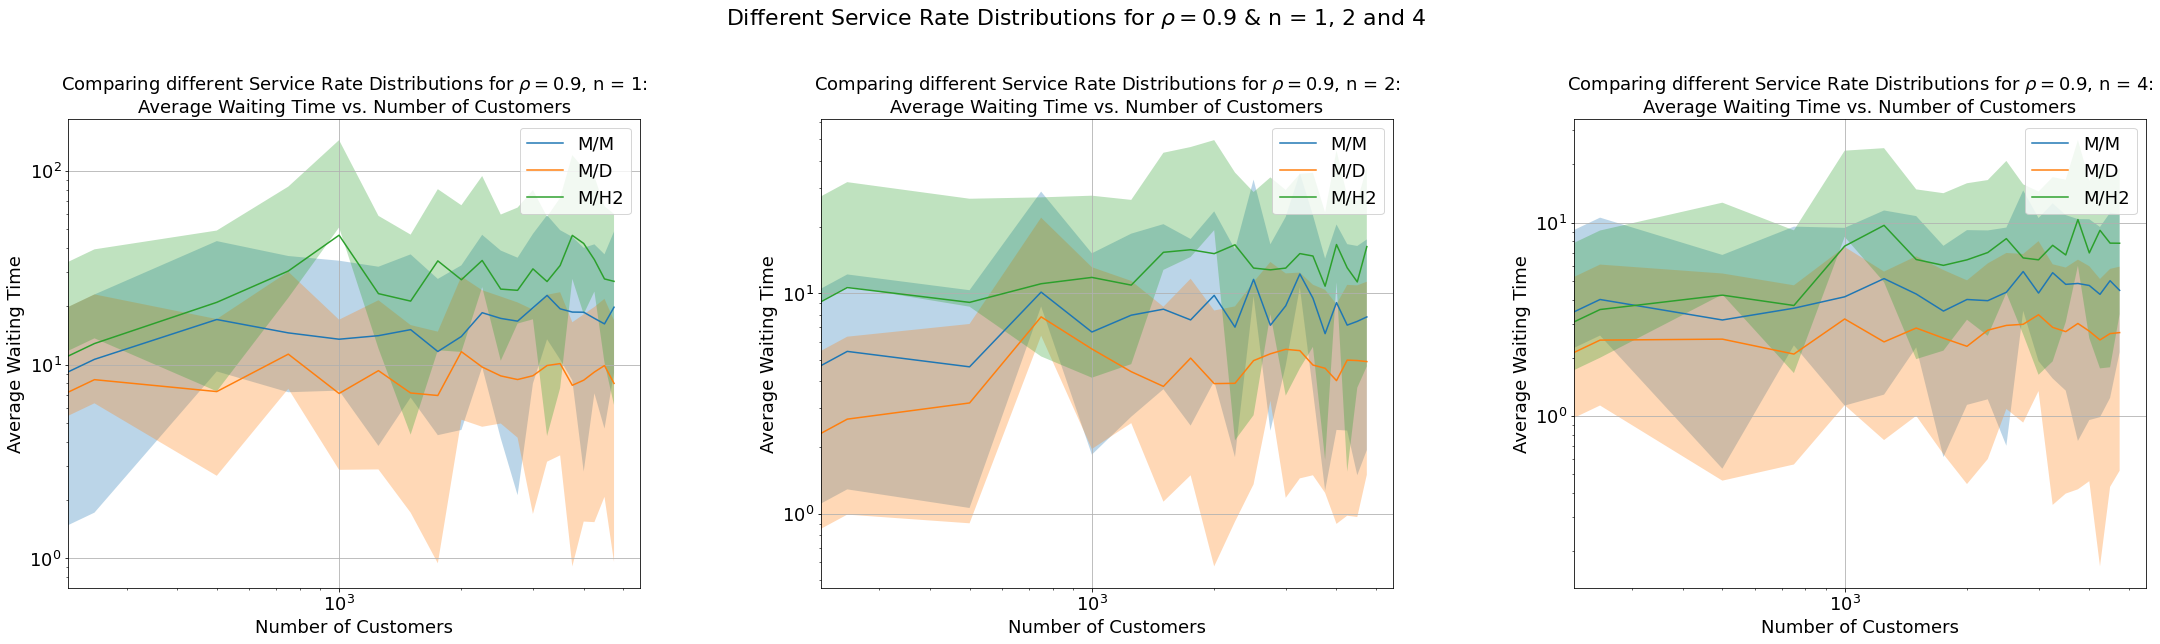

In [7]:
def service_rate_comparisons():
    num_simulations = 5
    num_customers_values = np.arange(0, 5000, 250)
    rho = 0.9
    mu = 1/2
    service_distributions = ['M', 'D', 'H2']  # Exponential, Deterministic, Hyper-2

    # Store results in DF
    results_df2 = pd.DataFrame(columns=['Service Distribution', 'n', 'Num Customers', 'Avg Waiting Time', 'Confidence Interval'])

    plt.figure(figsize=(30, 10))
    plt.suptitle(f'Different Service Rate Distributions for $\\rho = {rho}$ & n = 1, 2 and 4', fontsize=22)

    for i, n in enumerate([1, 2, 4], start=1):
        plt.subplot(1, 3, i)
        plt.title(f'Comparing different Service Rate Distributions for $\\rho = {rho}$, n = {n}:\nAverage Waiting Time vs. Number of Customers', fontsize=18)
        plt.xlabel('Number of Customers', fontsize=18)
        plt.ylabel('Average Waiting Time', fontsize=18)

        for service_distr in service_distributions:
            avg_waiting_times = []
            confidence_intervals = []

            for num_customers in num_customers_values:
                simulation_results = []

                for _ in range(num_simulations):
                    env = simpy.Environment()
                    mmn_queue = MMNQueue(env, n, rho, mu, service_distr=service_distr)
                    mmn_queue.run_simulation(num_customers)

                    if mmn_queue.total_complete_services > 0:
                        avg_waiting_time_one_sim = mmn_queue.total_time_in_queue / mmn_queue.total_complete_services
                        simulation_results.append(avg_waiting_time_one_sim)
                    else:
                        simulation_results.append(0)

                avg_waiting_time_over_sims, confidence_interval = calculate_confidence_interval(simulation_results)
                avg_waiting_times.append(avg_waiting_time_over_sims)
                confidence_intervals.append(confidence_interval)

                # Add to DF
                results_df2 = pd.concat([results_df2, pd.DataFrame({
                    'Service Distribution': [service_distr],
                    'n': [n],
                    'Num Customers': [num_customers],
                    'Avg Waiting Time': [avg_waiting_time_over_sims],
                    'Confidence Interval': [confidence_interval]
                })], ignore_index=True)

            # Plot the average waiting time
            plt.loglog(num_customers_values, avg_waiting_times, label=f'M/{service_distr}')

            # Plot the shaded confidence interval
            plt.fill_between(num_customers_values,
                             np.array(avg_waiting_times) - np.array(confidence_intervals)[:, 0],
                             np.array(avg_waiting_times) + np.array(confidence_intervals)[:, 1],
                             alpha=0.3)

        plt.legend(fontsize=18)  # Add legend with 'rho'
        plt.grid(True)

        # Increase font size of x and y-axis tick labels
        plt.tick_params(axis='both', which='both', labelsize=18)
    plt.tight_layout(rect=[0, 0.09, 1, 0.95], h_pad=2.0, w_pad=12)
    plt.savefig(f'output_{service_distributions}.png')  # Save the plot as a PNG file
    plt.show()

    return results_df2

results2 = service_rate_comparisons()